## Neural likelihood function
Two weeks ago, we talked about perception as probabilistic inference and evidence of close-to-Bayesian inference in the brain.

In this tutorial, let's write some code to understand better how a neural population can represent likelihood of a stimulus! It is largely based on Chapter 14 of the book ["Bayesian models of perception and action"](https://www.cns.nyu.edu/malab/bayesianbook.html)

First, let's import some python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%autosave 60

Autosaving every 60 seconds


### Poisson distribution and Poisson neurons

As we discussed, the number of action potentials (spikes) of a neuron typically has a property that the variance of the number of spikes scales with the mean of the number of spikes. When the ratio is 1, the distribution of the number of spikes, $r$, in a fixed time interval $t$ is well described by a Poisson distribution:
$$
p(r) = {1\over{r!}} e^{-\lambda t} {(\lambda t)}^r
$$

$\lambda$ is the firing rate. For simplicity, we can consider the number of spikes in $t$ = 1 second and ignore $t$:
$$
p(r) = {1\over{r!}} e^{-\lambda } {\lambda}^r
$$


$r!$ is called factorial of $r$: $r! = 1 \times 2 \times 3 \ldots \times r$
#### Simulate a neuron's spike counts
Now let's generate some samples of spike count for a neuron that on average fires 10 spikes per second!

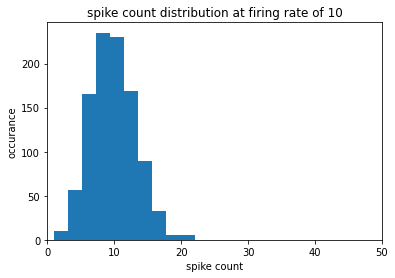

In [2]:
firing_rate = 10
n_observation = 1000

spike_counts = stats.poisson.rvs(mu=firing_rate, size=n_observation)
# rvs stands for random variates. 
# It generates random samples of a distribution based on te parameters you give
# mu is the mean of the distribution, which is the rate of Poisson distribution lambda

plt.hist(spike_counts)
plt.xlabel('spike count')
plt.ylabel('occurance')
plt.title('spike count distribution at firing rate of {}'.format(firing_rate))
plt.xlim([0, 50])
plt.show()

#### Practice: try a few different firing rates in the code above to see how the distribution changes.
<span style='color:red'> - For example, try 1, 3, and 30 Hz</span>
    
- Did you notice how the width of the distribution change with the center of the distribution?</span>

#### We can look at the relationship between the variance and mean of Poisson distribution by a new simulation


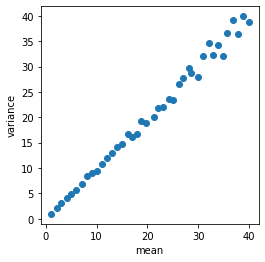

In [3]:
firing_rates = np.arange(1, 41)
n_observation = 1000

spike_counts = stats.poisson.rvs(mu=firing_rates, size=(n_observation, len(firing_rates)))
# Notice in the line above, the mu is a vector, and the size we request has the same lenght as mu in its second dimension
# Due to the default broadcasting rule, this means each element of mu applies to all samples in each column of the generated Poisson random variables.

plt.scatter(np.mean(spike_counts, axis=0), np.var(spike_counts, axis=0))
plt.xlabel('mean')
plt.ylabel('variance')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

### Tuning curve
Neurons typically show different levels of responses to different situations. This allows them to analyze and extract information from the external sensory inputs. For examples, neurons in visual cortex V1 are excited by edges in certain orientations in images, but show less response to different orientations. Neurons in auditory cortex A1 are excited by tones of certain frequencies. Such differential responses can be characterized by the so-called Tuning curves: how firing rate changes as a property of the stimuli.

For simplicity, let's use a Gaussian curve to describe a tuning curve of a neuron that shows preference for a range of values in a stimulus property (say, orientation of edges)

$$
f(s) = G e^{- {{(s - s_{pref})^2}\over{2 \sigma_{tc}^2}}} + b
$$

$G$ is the range of modulation by the stimulus. $b$ is the baseline firing rate. $\sigma_{t}$ describes the width of the tuning curve. $s_{pref}$ is the preferred stimulus of the neuron.

<span style='color:red'> - Please fill the incomplete line below so that we can plot a tuning curve</span>

Text(0.5, 1.0, 'An example tuning curve')

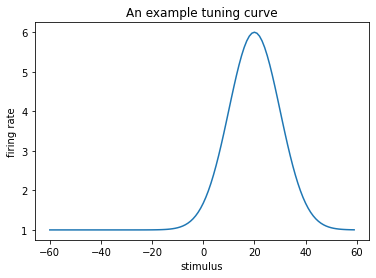

In [41]:
from numpy.ma.core import exp
stimuli = np.arange(-60, 60)
b = 1
G = 5
sigma_tc = 10
s_pref = 20

# Please complete the line below:
tuning_curve = G*np.exp(-(stimuli[:,None] - s_pref)**2/2/sigma_tc**2)+b

plt.plot(stimuli, tuning_curve)
plt.xlabel('stimulus')
plt.ylabel('firing rate')
plt.title('An example tuning curve')


### Likelihood function over stimulus based on a single neuron's spike count
Suppose we observe that the neuron fired 5 action potentials in a second, what stimulus is likely to have led this neuron to fire 5 spikes? You would probably guess that it should be a stimulus close to $s_{pref}$, based on the curve you observed.

How to capture this intuition?
Recall that we can describe the distribution of a neuron's spike count as a Poisson distribution. We can replace the firing rate $\lambda$ in the Poisson formula with the expected firing rate based on the tuning curve and any hypothetic stimulus:
$$
p(r|s) = {1\over{r!}} e^{-f(s) } {f(s)}^r
$$
This means that the neuron still has Poisson property, but instead of having a fixed firing rate, the expected firing rate depends on what stimulus is presented to the animal.

From another perspecive, for a given observation of spike count $r$, this would be a function of stimulus $s$, the likelihood function.

<span style='color:red'> - Now let's complete the following code to plot the likelihood function over stimulus for an observation of 5 action potential in one second from this neuron:</span>

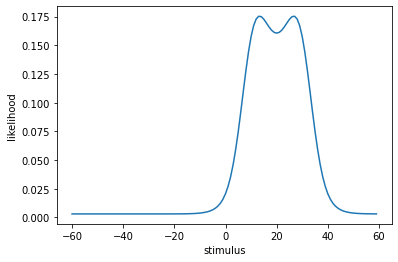

In [42]:
import math
spikes = 5


likelihood_single = stats.poisson.pmf(spikes, mu=tuning_curve)
# likelihood_single = 1/math.factorial(spikes) * np.exp(-tuning_curve) * (tuning_curve**spikes)
# pmf is short for probability mass function - the probability mass attributed to each possible value of a distribution.
# 
plt.plot(stimuli, likelihood_single)
plt.xlabel('stimulus')
plt.ylabel('likelihood')
plt.show()

<span style='color:red'> - Now let's analyze how the likelihood function changes with the number of spikes observed. For each value of spike counts from 0 to 9, calculate and plot the corresponding neural likelihood function. </span>

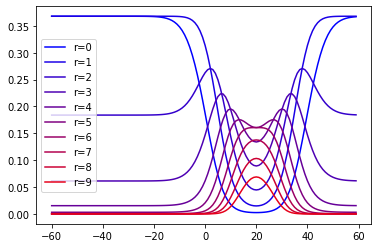

In [43]:
spikes = np.arange(0, 10)
# These are the spike numbers for which we want to investigate the likelihood function

red = np.asarray([1,0,0])
blue = np.asarray([0,0,1])
colors = (spikes[:,None] * red + (10 - spikes)[:,None] * blue) / 10
for idx, spike in enumerate(spikes):
    likelihood = stats.poisson.pmf(spike, mu=tuning_curve)
    plt.plot(stimuli, likelihood, label='r={}'.format(spike), color=colors[idx])
plt.legend()
plt.show()
    

You might have noticed that the likelihood functions do not sum to 1. Do their shapes make sense to you?


### A simplified example for neural likelihood based on a population of neurons

#### tuning curves
Let's make a simplifying assumption that we have a population of neurons with the same width of tuning curves and equally spaced preferred stimuli.

Please pay attention to how we calculate the matrix `tuning_curves` below. Each of its columns is the tuning curve of one neuron. Each of its rows is the expected firing rate over the population given one stimulus


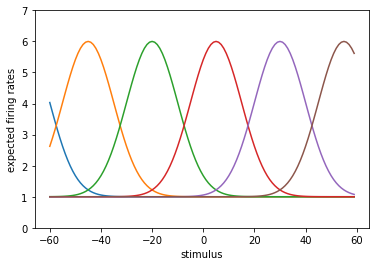

In [109]:
preferred_stimuli = np.arange(-70, 75, 20)


tuning_curves = G * np.exp( - (stimuli[:,None] - preferred_stimuli) ** 2 / 2 / sigma_tc ** 2) + b

plt.plot(stimuli, tuning_curves)
plt.ylim([0, 7])
plt.xlabel('stimulus')
plt.ylabel('expected firing rates')
plt.show()


#### Population activity
Let's sort the neurons based on their preferred stimuli, and draw a random sample of spike counts based on their tuning curves and the assumed Poisson property, when the actual stimulus is -20

<span style='color:red'> - Complete the code below to draw a sample of population spike counts. Hint: utilize the calculated tuning curves above and stats.poisson.rvs</span>

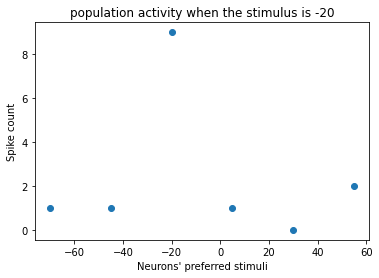

In [110]:
s = -20
# s: the stimulus

idx = np.argwhere(stimuli == s)[0][0]
# the index of stimulus in the range of all stimuli we are investigating

# How can we get the expected firing rates of each neuron, given all the quantities we have had so far?
expected_firing_rates = tuning_curves[idx]


# How can we draw a random sample of the number of spikes from the population of neurons assuming the follow Poisson property?
spike_counts = stats.poisson.rvs(mu=expected_firing_rates, size=np.shape(expected_firing_rates))


plt.scatter(preferred_stimuli, spike_counts)
plt.xlabel('Neurons\' preferred stimuli')
plt.ylabel('Spike count')
plt.title('population activity when the stimulus is {}'.format(s))
plt.show()

It looks pretty noisy, right?
But it roughly looks like a bell shape centered around the actual stimulus.
What would be your guess of the true stimulus `s` if I have not told you, by seeing this population activity? You are probably not very certain, but you may think it is more likely to be in certain range than other ranges, right? Your intuition is correct.

How can we read out the likelihood of the stimulus based on these observed numbers of spikes?

If we assume that each neuron's fluctuation of number of spikes around its expected firing rate is independent from other neurons, then the probability of observing all the spike counts is equal to the product of the propability of observing each individual neuron's spike count.

$$
p(\vec{r}|s) = \prod_i^N p(r_i|s) = \prod_i^N {1\over{r_i!}} e^{-f_i(s) } {f_i(s)}^r_i
$$

In the equation above, $r_i$ is the spike count of neuron $i$. Since we already had a vector `spike_counts` which covers the spike counts of all neurons in this population, this should be easy for you to extract. $f_i(s)$ is the tuning curve of the $i$'s neuron, which is also included in the matrix `tuning_curves`. You can either directly plug both of them into the equation above, or use `stats.poisson.pmf` to calculate the likelihood for each neuron.

<span style='color:red'> - Let's give a try of calculating the population neural likelihood?</span>

Text(0, 0.5, 'population neural likelihood')

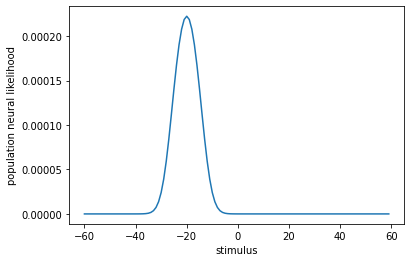

In [111]:
population_neural_likelihood = np.prod(stats.poisson.pmf(spike_counts, tuning_curves), axis=1)

plt.plot(stimuli, population_neural_likelihood)
plt.xlabel('stimulus')
plt.ylabel('population neural likelihood')

Hopefully, you would have obtained a bell-shaped curve centered around a value close to -20. 

<span style='color:red'>- Now you can run the two Code cells above for multiple times, you might find that each time the likelihood function is centered at different position. Why is this the case?</span>

<span style='color:red'>- Try to change the number of neurons (for example, by changing the gap between the preferred stimulus between consecutive neurons) and observe the effect on the likelihood function. </span>

<span style='color:red'>- Try to change the tuning width or the gain ($G$) of neurons, and observe the consequence on the likelihood function. </span>


In [ ]:
## This is due to noise in neurons.

For preferred_stimuli:
Neurons = 10, the curve is similar to 5
Neurons = 3, the curve shifts to the left (around -23)


### Connection to our discussion about "measurement" of a stimulus in the brain
You may remember that two weeks ago, we discussed the concept of an internal "measurement" `x` of an external stimulus `s` (for example, think of  the true speed or distance of a car as `s` and an internal estimate or measure of it based on low-level neural activity as `x`). We did not discuss too much how such `x` can arise. The description of `x` there is more or less an abstraction so that we can perform useful analysis of human or animals' behavior. In the end, if we have to always simulate a neural population in order to characterize behavior, our capacity is too much limited. So we have to come up with some simplication.

One way to think of `x` could be that it is an estimate of `s` based on the neural likelihood we are analyzing here. For example, a neural circuit may have learned to approximate the maximum likelihood estimation of the stimulus `s` by where the peak of the likelihood function is.   



#### optional excercise: simulating our perception when watching [ventriloquism](https://en.wikipedia.org/wiki/Ventriloquism)
Can you simulate two population of neurons representing auditory and visual representation of the location of sound source or an object in sight? Then can you implement cue integration based on these two populations of neuron such that the perception of the location of the speaking puppet is biased towards the puppet instead of the performer?
